In [23]:
import sys
sys.path.append('../../src')
from config import Paths
import pandas as pd

df = pd.read_csv(Paths.testnino1_classification_task, usecols=['id', 'Lang', 'Data', 'Link', 'Titolo', 'Testo', 'Stato Workflow'])

df['Data'] = pd.to_datetime(df['Data'])

target_column = 'Stato Workflow'

# remove rows not validated by the analyst
df = df[df[target_column] != 'N']

lang = 'all'
# df = df[df['Lang'] == lang]

print(df.dtypes)
print(df.shape)

df

id                         int64
Data              datetime64[ns]
Link                      object
Titolo                    object
Testo                     object
Lang                      object
Stato Workflow            object
dtype: object
(6857, 7)


,id,Data,Link,Titolo,Testo,Lang,Stato Workflow
21,1183085712,2023-10-01,http://www.instagram.com/p/Cx4rX8bIpqk,Carmine Abate Architetto - carmine_abate_archi...,Carmine Abate Architetto - carmine_abate_archi...,IT,Y
147,1183650630,2023-10-01,http://www.instagram.com/p/Cx3WMtZt7TU,Hotel Muchele - hotel_muchele (5040069464),Hotel Muchele - hotel_muchele (5040069464) 42 ...,EN,Y
148,1183650631,2023-10-02,http://www.instagram.com/p/Cx31kqFJtS0,AdrianaValle PatriciaCarvalho - migsarquitetur...,AdrianaValle PatriciaCarvalho - migsarquitetur...,EN,Y
152,1183731635,2023-10-02,http://www.instagram.com/p/Cx38Y5ZysBx,miya《東京カフェ巡り》 - miya_tokyocafe (40616149605),miya《東京カフェ巡り》 - miya_tokyocafe (40616149605) 2...,JA,Y
155,1183875489,2023-10-02,http://www.instagram.com/p/Cx4KaQbPMMx,✴︎an yuma✴︎ interior/life/beauty... - anyuma_n...,✴︎an yuma✴︎ interior/life/beauty... - anyuma_n...,JA,Y
...,...,...,...,...,...,...,...
12832,1210172722,2023-10-31,https://twitter.com/matt_meeta/status/17195000...,matt_meeta@twitter.com (Fridtjof Meeta),"matt_meeta@twitter.com (Fridtjof Meeta) ph5, p...",EN,Y
12833,1210172729,2023-10-31,https://twitter.com/HB/status/1719472193057206768,HB@twitter.com (House Beautiful UK),HB@twitter.com (House Beautiful UK) Why every ...,EN,Y
12835,1210277547,2023-10-31,https://internityhome.pl/inspiracje/koncept-na...,Koncept na dom w klimacie przytulnego loftu | ...,Koncept na dom w klimacie przytulnego loftu | ...,PL,D
12837,1210710403,2023-10-31,https://www.elle.se/decoration/snygga-bordslam...,Snygg bordslampa 2023 – snygga köp till hemmet...,Snygg bordslampa 2023 – snygga köp till hemmet...,SV,Y


Stato Workflow
D    4225
Y    2632
Name: count, dtype: int64


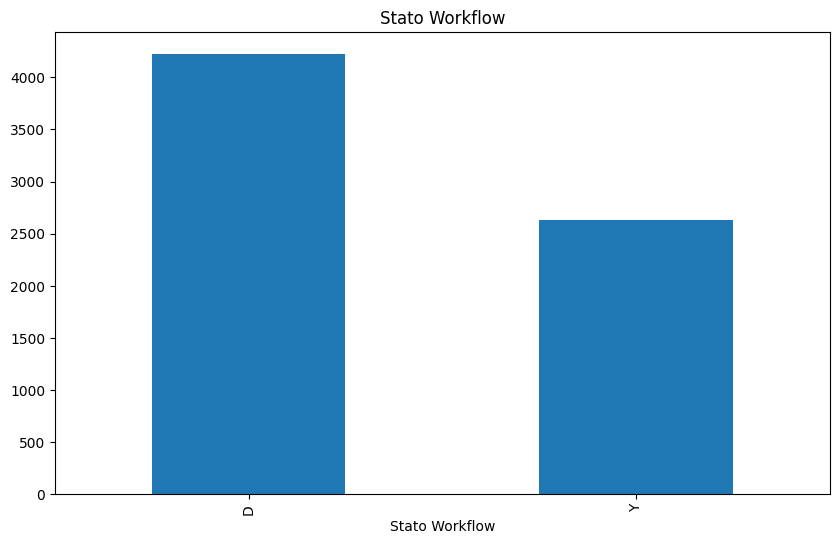

In [24]:
import matplotlib.pyplot as plt

column_counts = df[target_column].value_counts()
print(column_counts)
column_counts.plot(kind='bar', figsize=(6, 4))
plt.title(target_column)
plt.show()


In [25]:
import time
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier


classifiers = [
    GradientBoostingClassifier(random_state=42),
    KNeighborsClassifier(n_jobs=-1),
    SVC(random_state=42),
    GaussianProcessClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=42),
    LinearDiscriminantAnalysis(),
    ExtraTreesClassifier(n_jobs=-1, random_state=42),
    SGDClassifier(random_state=42)
]

datasets = {
    25: [],
    50: [],
    100: [],
    200: [],
    500: [],
    750: [],
    1000: [],
}

# create balanced X_train and y_train
class_Y = df[df["Stato Workflow"] == "Y"]
class_D = df[df["Stato Workflow"] == "D"]
for key in datasets.keys():
    # Sample N instances from each class
    sampled_Y = class_Y.sample(int(key / 2), random_state=42)
    sampled_D = class_D.sample(int(key / 2), random_state=42)

    # Concatenate the results
    balanced_train = pd.concat([sampled_Y, sampled_D])
    balanced_X_train = balanced_train["Testo"]
    balanced_y_train = balanced_train["Stato Workflow"]

    filtered_df = df[~df.isin(balanced_X_train)].dropna()

    X_train, X_test, y_train, y_test = train_test_split(
        filtered_df["Testo"],
        filtered_df["Stato Workflow"],
        random_state=42,
        train_size=key,
    )

    # use balanced X train
    datasets[key] = [balanced_X_train, X_test, balanced_y_train, y_test]

cms = {}
accuracies = {}
fit_times = {}
prediction_times = {}


# Create a FunctionTransformer to convert sparse matrices to dense ones
to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

# Create pipelines
for clf in classifiers:
    # Create a separate pipeline for the classifiers neededng dense vectors
    if (
        isinstance(clf, GaussianProcessClassifier)
        or isinstance(clf, GaussianNB)
        or isinstance(clf, QuadraticDiscriminantAnalysis)
        or isinstance(clf, LinearDiscriminantAnalysis)
    ):
        pipeline = Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("to_dense", to_dense),
                ("clf", clf),
            ]
        )
    else:
        pipeline = Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", clf),
            ]
        )

    for key in datasets.keys():
        model_name = f"{key}-{clf.__class__.__name__}-{clf.get_params()}"
        X_train = datasets[key][0]
        X_test = datasets[key][1]
        y_train = datasets[key][2]
        y_test = datasets[key][3]

        print("***************************************************************")
        print(f"Evaluating model {model_name}...")
        try:
            start_time = time.time()
            pipeline.fit(X_train, y_train)
            fit_time = time.time() - start_time
            fit_times[model_name] = fit_time

            start_time = time.time()
            y_pred = pipeline.predict(X_test)
            prediction_time = time.time() - start_time
            prediction_times[model_name] = prediction_time

            cm = confusion_matrix(y_test, y_pred)
            cms[model_name] = cm

            accuracy = accuracy_score(y_test, y_pred)
            accuracies[model_name] = accuracy

            print(f"{model_name}")
            print(f"{accuracy:.2f}")
            print("***************************************************************\n\n")
        except Exception as e:
            print(f"An error occurred: {str(e)}")

import pickle

# Save the dictionaries to a file
with open(f"results_{lang}.pkl", "wb") as file:
    pickle.dump(cms, file)
    pickle.dump(accuracies, file)
    pickle.dump(fit_times, file)
    pickle.dump(prediction_times, file)

***************************************************************
Evaluating model 25-GradientBoostingClassifier-{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}...
25-GradientBoostingClassifier-{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0,

In [26]:
for model_name, accuracy in accuracies.items():
    print(model_name)
    print(f"{accuracy:.2f}")
    print(f"{cms[model_name]}")
    print(f"fit_time: {fit_times[model_name]:.2f}")
    print(f"prediction_time: {prediction_times[model_name]:.2f}")
    print()


25-GradientBoostingClassifier-{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.63
[[2702 1494]
 [1044 1568]]
fit_time: 0.31
prediction_time: 0.69

50-GradientBoostingClassifier-{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start':